In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#SQL Handler Functions
#send query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
#send command
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
#show tables
def show_tables():
    r = """SELECT
        name,
        type
        FROM sqlite_master
        WHERE type IN ("table","view");"""
    return run_query(r)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
fetch_genre = """
With track_genre AS (SELECT
                     t.track_id, g.name genre
                     FROM track t
                     INNER JOIN genre g ON
                     g.genre_id = t.genre_id),
    inv_genre AS (SELECT
                      il.invoice_id, tg.genre
                  FROM
                      invoice_line il
                  INNER JOIN track_genre tg ON tg.track_id = il.track_id),
    inv_con AS (SELECT ig.genre, COUNT(ig.invoice_id) tracks
                FROM invoice i
                INNER JOIN inv_genre ig ON ig.invoice_id = i.invoice_id
                WHERE i.billing_country LIKE 'USA'
                GROUP BY ig.genre
                ORDER BY 2 DESC),
    total_Tracks AS (SELECT SUM(tracks) stot FROM inv_con)
            
SELECT genre, tracks, ROUND(100*CAST(tracks as FLOAT)/(Select * FROM total_Tracks),2) perGenre 
FROM inv_con
            """
ts = run_query(fetch_genre)
run_query(fetch_genre)

,genre,tracks,perGenre
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


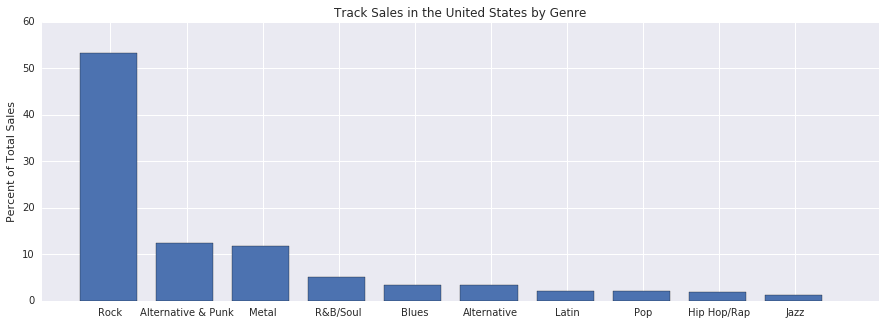

In [5]:
num = 10
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(np.arange(0,num)+.5,ts.perGenre[0:num],width = .75)
ax.set_xlim(0,num+1)
ax.set_xticks(np.arange(0,num)+.9)
ax.set_xticklabels(ts.genre[0:num])
plt.ylabel('Percent of Total Sales')
plt.title('Track Sales in the United States by Genre')
plt.show()

The four album genres (blues, punk, pop and hip-hop)  are in the bottom 20% of track sales by genre in the USA (if the data is to be believed).  The company should focus on Rock which accounts for more than 50% of sales...

In [6]:
query_agent = """
WITH cust_tot AS (SELECT
                    i.customer_id, c.support_rep_id, SUM(i.total) total_pur
                  FROM 
                    invoice i
                  LEFT JOIN customer c ON c.customer_id=i.customer_id
                  GROUP BY c.customer_id)
SELECT
    (e.first_name || " " || e.last_name) agent_name,
    e.title Title,
    SUM(ct.total_pur) Total_Sales,
    e.hire_date
    FROM employee e
    INNER JOIN cust_tot ct ON ct.support_rep_id = e.employee_id
    GROUP BY e.employee_id
            """
ag = run_query(query_agent)
ag['Total_Sales'] = ag['Total_Sales'].astype(float)
ag['hire_date'] = pd.to_datetime(ag['hire_date'])
run_query(query_agent)


,agent_name,Title,Total_Sales,hire_date
0,Jane Peacock,Sales Support Agent,1731.51,2017-04-01 00:00:00
1,Margaret Park,Sales Support Agent,1584.00,2017-05-03 00:00:00
2,Steve Johnson,Sales Support Agent,1393.92,2017-10-17 00:00:00


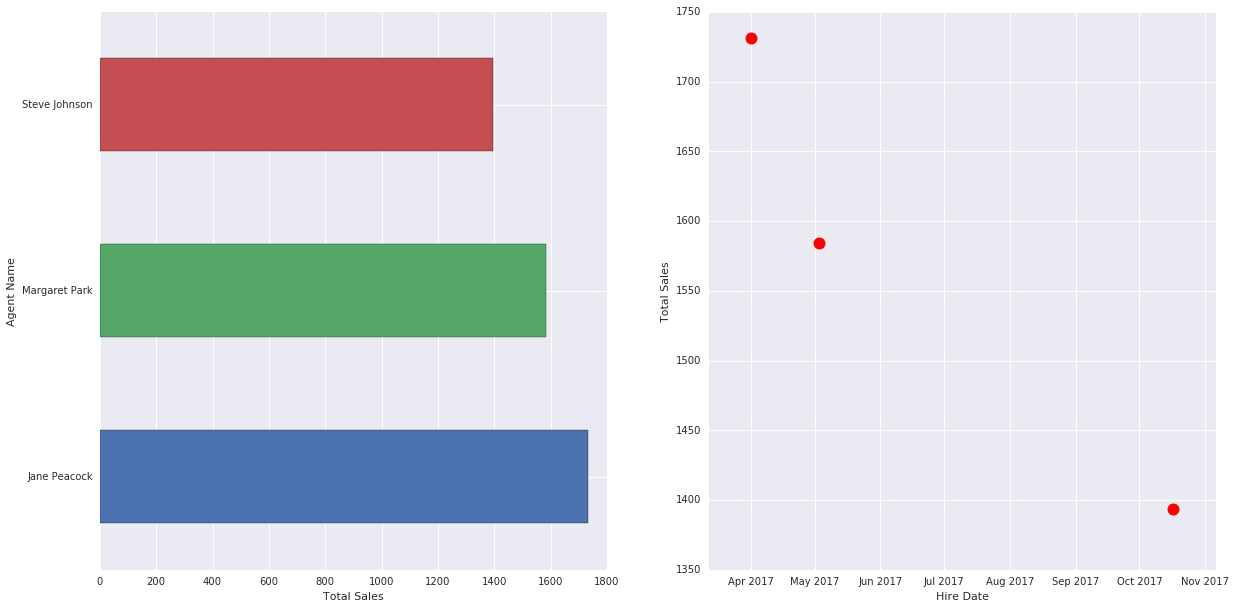

In [7]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ag.plot.barh(x='agent_name',y='Total_Sales',ax=ax1)
plt.gca().get_legend().remove()
plt.xlabel('Total Sales')
plt.ylabel('Agent Name')
ax2 = fig.add_subplot(1,2,2)
plt.plot(ag.hire_date,ag.Total_Sales,'ro',markersize=12)
t = ax2.get_xlim()
ax2.set_xlim(t[0]-20,t[1]+20)
plt.xlabel('Hire Date')
plt.ylabel('Total Sales')
plt.show()

Jane Peacock has the largest total sales, but she's also the agent that has been there the longest.  There is a strong correlation between hire date and performance.

In [8]:
customer_data = """

WITH 
/*customer data*/
cust_data AS (SELECT
                    c.customer_id,
                    c.country,
                    SUM(i.total) tot_pur,
                    COUNT(i.total) num_ord
                   FROM
                    customer c
                   LEFT JOIN invoice i ON i.customer_id=c.customer_id
                   GROUP BY 1),
/*country data*/
country_data AS (SELECT
                          country,
                          COUNT(customer_id) tot_customers,
                          SUM(tot_pur) total_value,
                          ROUND(SUM(tot_pur)/COUNT(customer_id),2) ave_sales_per_customer,
                          ROUND(SUM(tot_pur)/SUM(num_ord),2) aver_order_value,
                          CASE
                              WHEN COUNT(customer_id) = 1 THEN 1
                              ELSE 0
                          END AS individ
                      FROM
                          cust_data
                      GROUP BY 1
                      ),
/*Country Data with Other ROW*/                      
country_data_wo AS ( SELECT
                          country,
                          tot_customers,
                          total_value,
                          ave_sales_per_customer,
                          aver_order_value,
                          individ
                      FROM
                          country_data
                      WHERE individ = 0
                      UNION
                      SELECT
                          "Other" AS country,
                          SUM(tot_customers) AS tot_customers,
                          SUM(total_value) AS total_value,
                          SUM(total_value)/SUM(tot_customers) AS ave_sales_per_customer,
                          SUM(total_value)/SUM(total_value/aver_order_value) AS aver_order_value,
                          individ
                      FROM
                          country_data
                      WHERE individ = 1
                      GROUP BY individ
                      ORDER BY 3 DESC
                      )                      
SELECT country, tot_customers,total_value,ROUND(ave_sales_per_customer,2) ave_sales_cust,ROUND(aver_order_value,2) ave_order_val
FROM country_data_wo
ORDER BY individ ASC
            """
cd = run_query(customer_data)
run_query(customer_data)

,country,tot_customers,total_value,ave_sales_cust,ave_order_val
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.56,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


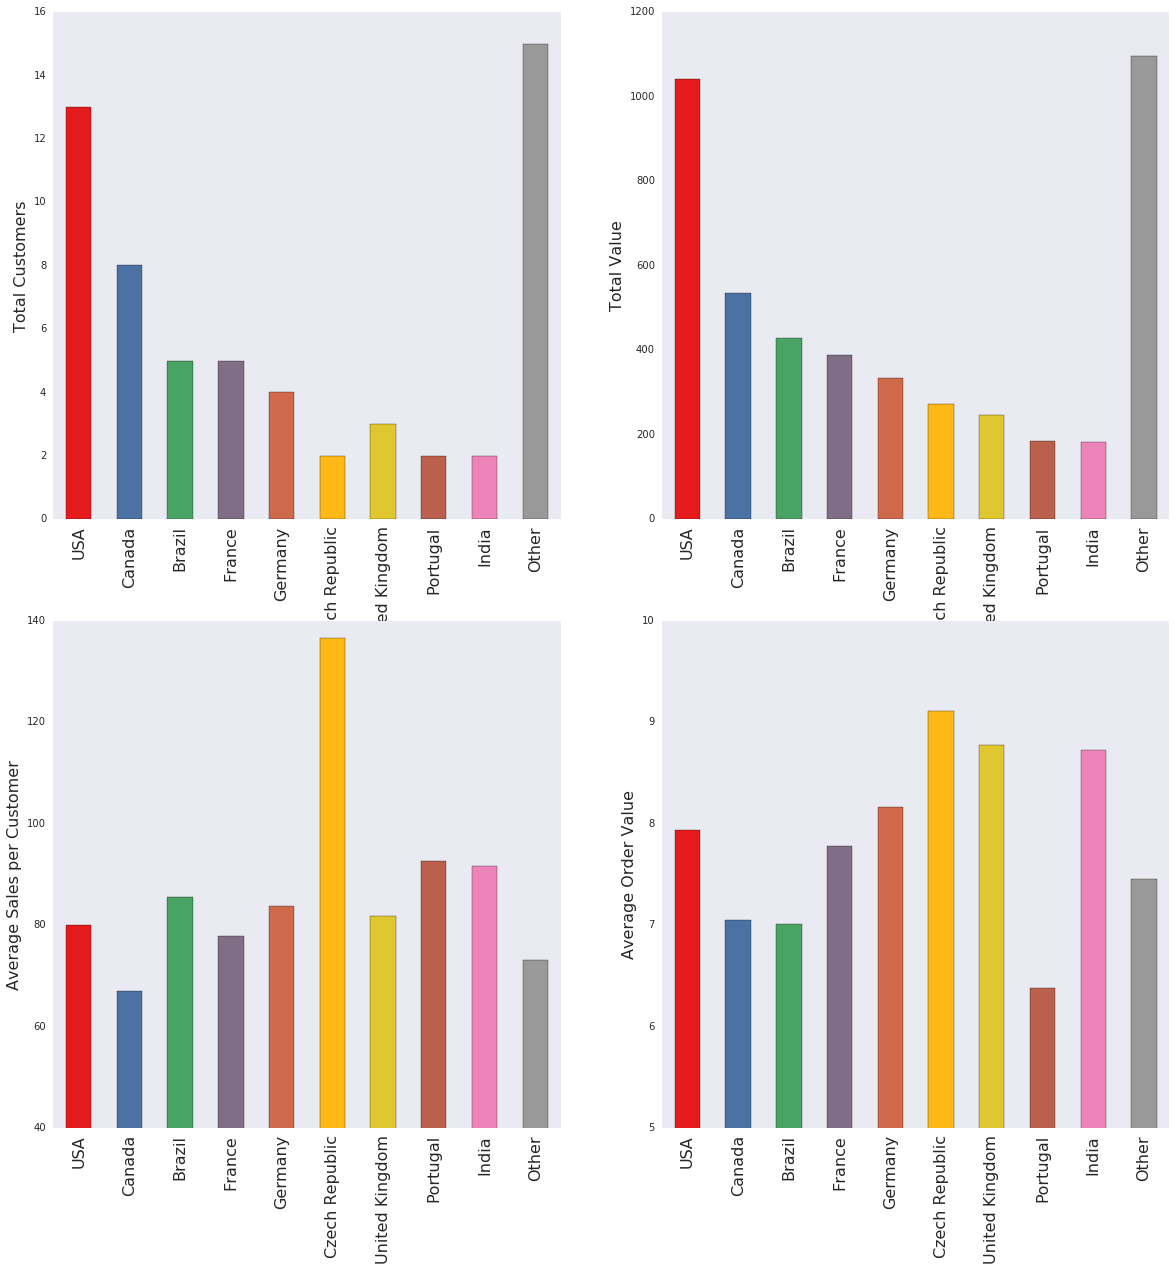

In [9]:
from matplotlib import cm

c = cm.Set1(np.linspace(0,1,cd.shape[0]))
fig = plt.figure(figsize=(20,20))

ytitles = {0:'Total Customers',1:'Total Value',2:'Average Sales per Customer',3:'Average Order Value'}
ylims = {2:(40,140),3:(5,10)}
for i in range(0,4):
    ax1 = fig.add_subplot(2,2,i+1)
    cd.plot(x="country",y=cd.columns[i+1],ax=ax1,kind='bar', stacked=True,
        color=c)
    ax1.set_xticklabels(cd.country,fontsize=16)
    ax1.set_xlabel(" ")
    ax1.get_legend().remove()
    ax1.set_ylabel(ytitles[i],fontsize=16)
    if i>1:
        ax1.set_ylim(ylims[i])
    sns.despine(ax=ax1,bottom=True,left=True,right=True,top=True)
    ax1.grid(False)
plt.show()

Despite the US and Canada being the biggest customers, the largest sale average occurs in the Czeck Rep.  An increased marketing campaign in Europe could pay dividends...

In [26]:
album_or_track = """
WITH 
/*Table of Invoices and their first track*/                         
invoice_tracklist AS (SELECT il.invoice_id, il.track_id
                      FROM invoice_line il
                      GROUP BY 1
                      ORDER BY 1 ASC
                      )
SELECT album_purchase, 
       count(invoice_id) Number_of_Invoices,
       ROUND(100*CAST(count(invoice_id) as FLOAT)/(SELECT COUNT(*) FROM invoice),2) AS Percentage_of_invoices
FROM
    (
        SELECT itl.*, CASE
                        WHEN
                            (/*Find the tracks which occur on the same album as the invoice first track*/
                            SELECT t.track_id FROM track t
                            WHERE t.album_id = (
                                                SELECT t2.album_id FROM track t2
                                                WHERE t2.track_id = itl.track_id)
                            EXCEPT
                            /*Find all the tracks linked with that invoice id*/    
                              SELECT il2.track_id FROM invoice_line il2
                              WHERE il2.invoice_id = itl.invoice_id
                            ) IS NULL
                            AND
                            (/*Find all the tracks linked with that invoice id*/    
                              SELECT il2.track_id FROM invoice_line il2
                              WHERE il2.invoice_id = itl.invoice_id
                            EXCEPT
                            /*Find the tracks which occur on the same album as the invoice first track*/
                            SELECT t.track_id FROM track t
                            WHERE t.album_id = (
                                                SELECT t2.album_id FROM track t2
                                                WHERE t2.track_id = itl.track_id)
                            ) IS NULL
                    THEN "yes"
                    ELSE "no"
                    END as album_purchase
        FROM invoice_tracklist itl
    )
GROUP BY album_purchase                      
"""
aot = run_query(album_or_track)
run_query(album_or_track)

,album_purchase,Number_of_Invoices,Percentage_of_invoices
0,no,500,81.43
1,yes,114,18.57


Given that the bulk of the sales (>80%) are album purchases, it would be unwise to buy more than the 81%.